# <center>Test Notebook for Non Gaussian initial conditions in 21cmFirstCLASS</center>
### <center>By S. Libanore and K. Finish</center>

This notebook is used to check and debug the changes we made on the .py and .c files of 21cmFirstCLASS in order to introduce and study non Gaussian models. <br>
All changes in the .py and .c files can be tracked using the string '# !!! SLKF:' or 'SLKFnew'.

First of all, we import all the needed modules and we set the configuration for the plotting style.

In [1]:
# Import the packages required for this tutorial

import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt

import py21cmfast as p21c # To run 21cmFirstCLASS (21cmFAST)
from py21cmfast import plotting # For plotting global signals, coeval boxes, lightcone boxes and power spectra
import py21cmfast.power_spectrum as ps # Calculate power spectrum from the lightcone
from py21cmfast.inputs import global_params # Useful in this tutorial to plot the initial conditions for the simulation

import pickle
from copy import copy
from scipy.interpolate import interp1d

import astropy.units as u



------------------------------------------
!!! SLTK+SLKF: 23/08/24
We defined the SF efficiency function and the SFR function; we redefined how Mass_limit(_bisection) is computed.
SFRD and Nion call separately either the SFR and the efficiency when using Fcoll.
 We added to ps.c function to compute SFR, HMF and to the wrapper functions to extract SFR, HMF and to compute LF. 

 Added SFR model from Bin Yue and model II of GALLUMI.

 NOTE: in IonisationBox, there is only one point in which the SFRD is required instead of Nion.
 For the moment, we collect the extra factor in the ST_over_PS factor but this is based on the assumption that the ratio is mass independent.
 Moreover, this uses the average value in the box instead of the value per cell, which introduces a variation < 2perc in Tb, < 6perc in Pk.


Added Non Gaussian initial condition following Lidz et al. ; fcoll non Gaussian in progress.Removed USE_INTERPOLATION_TABLES = FALSE, USE_MASS_DEPENDENT_ZETA = FALSE, USE_HALO_FIELD = 

In [2]:
plt.rcParams.update({"text.usetex": True, "font.family": "Times new roman"}) # Use latex fonts
colors =  ['#377eb8', '#ff7f00', '#4daf4a',
           '#f781bf', '#a65628', '#984ea3',
           '#999999', '#e41a1c', '#dede00']

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) # Set the color palette as default

color_test = '#eb884d'

In [3]:
#plot transfer function
from classy import Class

# Cosmological parameters in LCDM -- ALWAYS THE SAME
cosmo_params = {"hlittle": 0.6736, # hubble parameter
                "OMb": 0.0493, # baryon density
                "OMm": 0.3153, # matter (CDM+baryon) density
                "A_s": 2.1e-9, # amplitude of the primordial fluctuations
                "POWER_INDEX": 0.9649, # spectral index of the primordial spectrum
                "tau_reio": 0.0544, # optical depth to reionization
                }

CLASS_params = {}
CLASS_params['h'] = cosmo_params['hlittle']
CLASS_params['Omega_cdm'] = (cosmo_params['OMm']+cosmo_params['OMb'])*cosmo_params['hlittle']**2
CLASS_params['Omega_b'] = cosmo_params['OMb']*cosmo_params['hlittle']**2
CLASS_params['A_s'] = cosmo_params['A_s']
CLASS_params['n_s'] = cosmo_params['POWER_INDEX']
CLASS_params['tau_reio'] = cosmo_params['tau_reio']
CLASS_params['output'] = 'tCl,pCl,lCl,mTk,vTk,mPk'
CLASS_params['lensing'] = 'yes'
CLASS_params['z_pk'] = 1087.
CLASS_params['l_max_scalars'] = 3000
# We need to run CLASS for very large wavenumbers. This is required for computing sigma(M) and the HMF
CLASS_params['P_k_max_1/Mpc'] = 1200.

CLASS_OUTPUT = Class()
CLASS_OUTPUT.set(CLASS_params)
CLASS_OUTPUT.compute()

print('sigma8 =' + str(CLASS_OUTPUT.sigma8()))

Transfer_0 = CLASS_OUTPUT.get_transfer(z=0.)

k_CLASS = Transfer_0['k (h/Mpc)'][:]*cosmo_params['hlittle'] # 1/Mpc
delta_m_0_CLASS = Transfer_0['d_tot'][:]
delta_phi_0_CLASS = Transfer_0['phi'][:]

 

---------------------------------------
SL: imported standard CLASS
---------------------------------------
sigma8 =0.6809696080354488


## Set up parameters for the new simulation

In this example notebook, we estimate the 21cm signal from recombination to reionization. <br>
We assume &Lambda;CDM cosmological parameters from Planck 2018.

In each run, the astrophysics is set in order to test the current level of code development.

In [3]:
# Parameters related with the size of the simulation itself and with the kind of outputs required -- ALWAYS THE SAME
user_params = {"BOX_LEN": 100, # size of the simulated box (in comoving Mpc) 
               "HII_DIM": 25, # number of cells along each axis of the coeval box - Note: more cells means longer runtime! 
               "N_THREADS": 6, # the amount of processors the code uses in parallelization
               "NG_FIELD":False,
               "EVOLVE_BARYONS":False
               } 

# Cosmological parameters in LCDM -- ALWAYS THE SAME
cosmo_params = {"hlittle": 0.6736, # hubble parameter
                "OMb": 0.0493, # baryon density
                "OMm": 0.3153, # matter (CDM+baryon) density
                "A_s": 2.1e-9, # amplitude of the primordial fluctuations
                "POWER_INDEX": 0.9649, # spectral index of the primordial spectrum
                "tau_reio": 0.0544, # optical depth to reionization
                "F_NL":0.,
                }


In [4]:
# Parameters related with the size of the simulation itself and with the kind of outputs required -- ALWAYS THE SAME
user_params_NG = {"BOX_LEN": 100, # size of the simulated box (in comoving Mpc) 
               "HII_DIM": 25, # number of cells along each axis of the coeval box - Note: more cells means longer runtime! 
               "N_THREADS": 6, # the amount of processors the code uses in parallelization
               "NG_FIELD":True,
               "EVOLVE_BARYONS":False
               } 

# Cosmological parameters in LCDM -- ALWAYS THE SAME
cosmo_params_NG0 = {"hlittle": 0.6736, # hubble parameter
                "OMb": 0.0493, # baryon density
                "OMm": 0.3153, # matter (CDM+baryon) density
                "A_s": 2.1e-9, # amplitude of the primordial fluctuations
                "POWER_INDEX": 0.9649, # spectral index of the primordial spectrum
                "tau_reio": 0.0544, # optical depth to reionization
                "F_NL":0.,
                }

# Cosmological parameters in LCDM -- ALWAYS THE SAME
cosmo_params_NG300 = {"hlittle": 0.6736, # hubble parameter
                "OMb": 0.0493, # baryon density
                "OMm": 0.3153, # matter (CDM+baryon) density
                "A_s": 2.1e-9, # amplitude of the primordial fluctuations
                "POWER_INDEX": 0.9649, # spectral index of the primordial spectrum
                "tau_reio": 0.0544, # optical depth to reionization
                "F_NL":300.,
                }

# Parameters that set the physical processes the code accounts for -- ALWAYS THE SAME
flag_options = {"USE_MINI_HALOS": False, } # if False, popIII stars are not included - Note: if set to True, the runtime increases significantly!


In [5]:
# Astrophysical parameters 
astro_params = {"SFR_MODEL": "MUN21", # !!! SLTK: our new input !!! 
                "F_STAR10": -1.25, # star formation efficiency (atomic cooling galaxies) for pivot mass 1e10 Msun (log10)
                "ALPHA_STAR": 0.5, # slope of the dependency of star formation efficiency on the host halo mass 
                "F_ESC10": -1.35, # escape fraction of Lyman photons into the IGM for pivot mass 1e10 Msun (log10)
                "ALPHA_ESC": -0.3, # slope of the dependency of escape fraction on the host halo mass 
                "L_X": 40.5, # X-ray luminosity (log10)
                "sigma_Muv":0.45 # the dispersion in the halo mass - UV magnitude relation
                }

In [ ]:
global_params.EVOLVE_DENSITY_LINEARLY = True

### Set up the required outputs

As in 21cmFAST, 21cmFirstCLASS allows you to extract the quantities evolved in the simulation using different formats.<br>
In this notebook, to save memory, we only rely on the aforementioned global quantities to compare with our benchmark model. We also include the lightcone quantities required to compute the power spectrum afterwards.

In [6]:
global_quantities = ("brightness_temp", # brightness temperature
                     "Tk_box", # kinetic temperature
                     "Ts_box", # spin temperature
                     "xH_box", # neutral hydrogen fraction
                     "J_Lya_box" # Lyman alpha flux - new feature in 21cmFirstCLASS! 
                     )
                     

coeval_quantities = ['density','brightness_temp']

input_coeval_redshifts = [6.,10.,15.,]

lightcone_quantities = ("brightness_temp",'density')

## Run the simulation

To run 21cmFirstCLASS we use the build-in 'run_lightcone' of 21cmFAST.<br>
Everything in 21cmFirstCLASS can then be accessed from the resulting lightcone object. <br>
We consider both dark ages and cosmic dawn, even if the astrophysical parameters only affect the latter, to be sure that the modifications that we implement do not affect the overall structure of the code.

In [8]:
lightcone = p21c.run_lightcone(redshift = 6., # minimum redshift at which the simulation will stop
                               random_seed = 1, # numerical seed -- if None, each run will produce different initial conditions, with the same cosmological power spectrum but different spatial realization. You need to specify the random seed to coherently compare two different runs, due to cosmic variance. 
                               regenerate = True, # create new data even if cached are found
                               write = False, # whether or no to save cached files
                               user_params = user_params,
                               astro_params = astro_params, 
                               flag_options = flag_options,
                               cosmo_params = cosmo_params,
                               global_quantities = global_quantities,
                               save_coeval_quantities = coeval_quantities,
                               save_coeval_redshifts = input_coeval_redshifts,
                               lightcone_quantities = lightcone_quantities) ; 

Now running CLASS...
Now generating initial boxes...
boxes->hires_density = 1.258005e+00 


21cmFAST (cosmic dawn): 100%|██████████| 84/84 [00:56<00:00,  1.48redshift/s]


Now evaluating tau to reionization and re-running CLASS...


In [7]:
lightcone_NG0 = p21c.run_lightcone(redshift = 6., # minimum redshift at which the simulation will stop
                              random_seed = 1, # numerical seed -- if None, each run will produce different initial conditions, with the same cosmological power spectrum but different spatial realization. You need to specify the random seed to coherently compare two different runs, due to cosmic variance. 
                              regenerate = True, # create new data even if cached are found
                              write = False, # whether or no to save cached files
                              user_params = user_params_NG,
                              astro_params = astro_params, 
                              flag_options = flag_options,
                              cosmo_params = cosmo_params_NG0,
                              global_quantities = global_quantities,
                              save_coeval_quantities = coeval_quantities,
                              save_coeval_redshifts = input_coeval_redshifts,
                              lightcone_quantities = lightcone_quantities) ; 

Now running CLASS...
---------------------------------------
SL: imported standard CLASS
---------------------------------------
Now generating initial boxes...
boxes->hires_density = 1.287949e+00 


21cmFAST (cosmic dawn):   0%|          | 0/84 [00:00<?, ?redshift/s]

: 

In [ ]:
lightcone_NG300 = p21c.run_lightcone(redshift = 6., # minimum redshift at which the simulation will stop
                              random_seed = 1, # numerical seed -- if None, each run will produce different initial conditions, with the same cosmological power spectrum but different spatial realization. You need to specify the random seed to coherently compare two different runs, due to cosmic variance. 
                              regenerate = True, # create new data even if cached are found
                              write = False, # whether or no to save cached files
                              user_params = user_params_NG,
                              astro_params = astro_params, 
                              flag_options = flag_options,
                              cosmo_params = cosmo_params_NG300,
                              global_quantities = global_quantities,
                              save_coeval_quantities = coeval_quantities,
                              save_coeval_redshifts = input_coeval_redshifts,
                              lightcone_quantities = lightcone_quantities) ; 

Now running CLASS...
Now generating initial boxes...
boxes->hires_density = 3.063509e+00 


21cmFAST (cosmic dawn): 100%|██████████| 84/84 [00:56<00:00,  1.50redshift/s]


Now evaluating tau to reionization and re-running CLASS...


### Coeval Boxes
Plotting coeval boxes in 21cmFirstCLASS is also easy. Unlike 21cmFAST, this can be achieved directly from the lightcone box object.

Note that when specifying the redshift of the coeval box to be plotted, the closest redshift from the stored coeval boxes is chosen.

NameError: name 'lightcone_NG300' is not defined

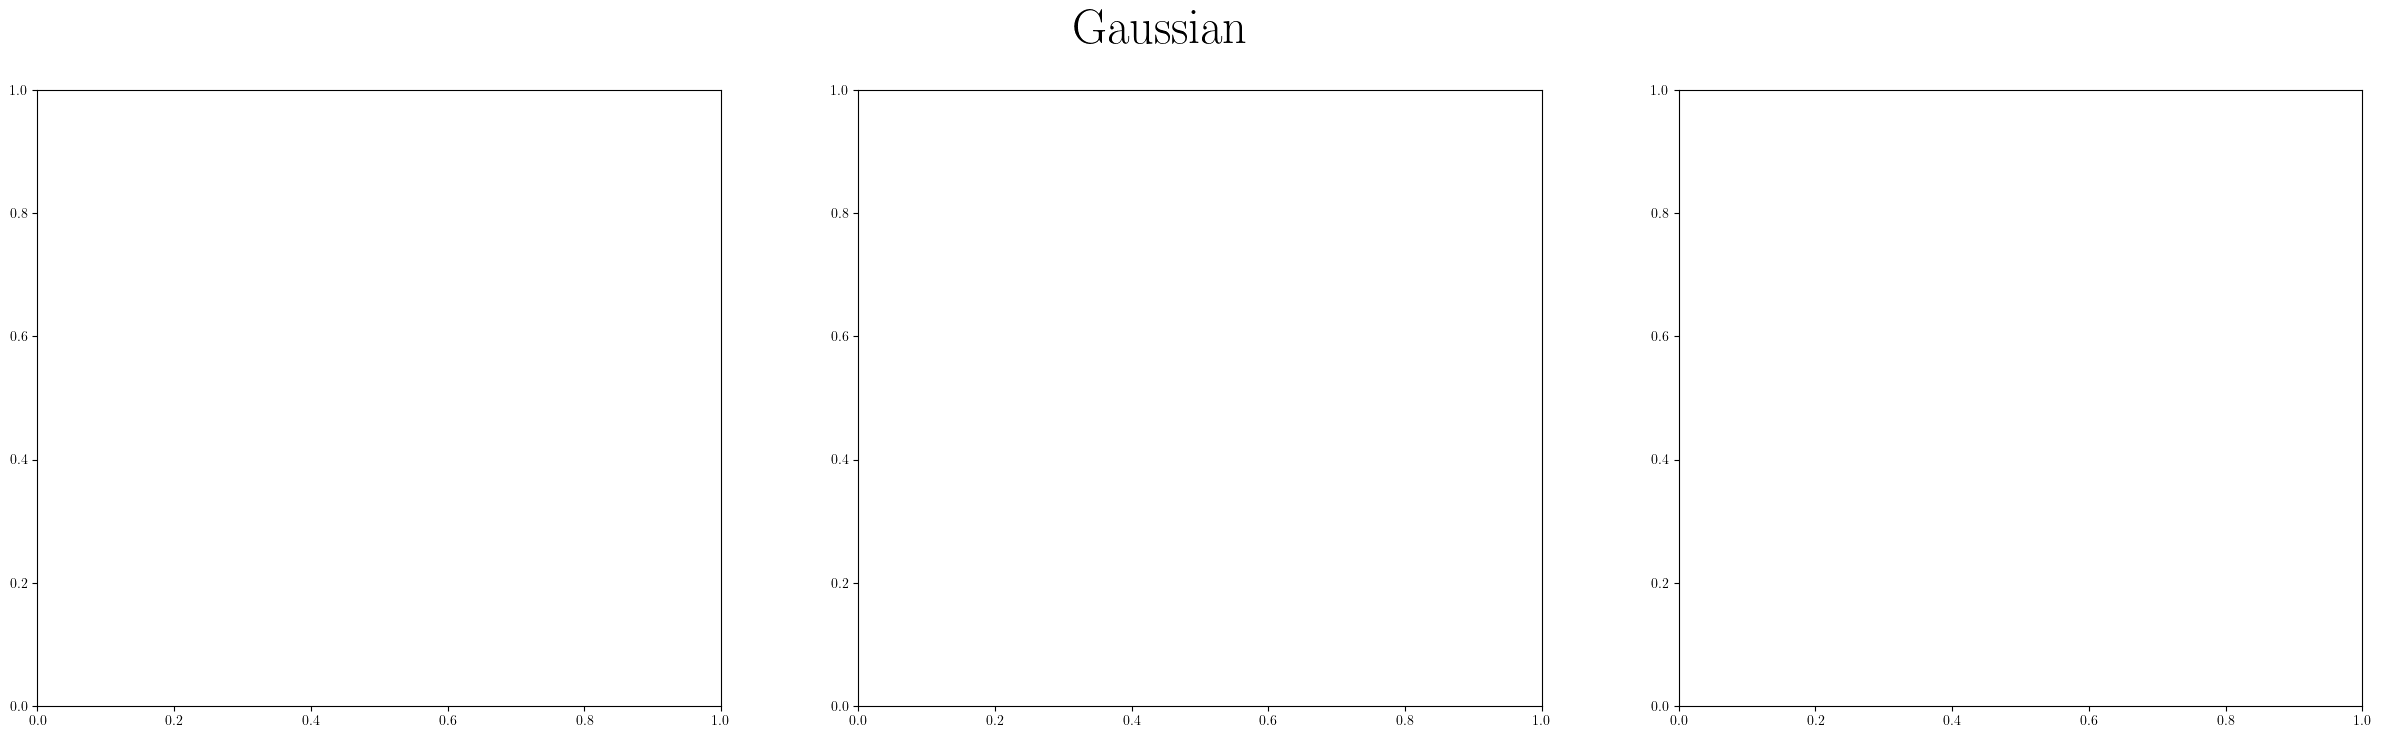

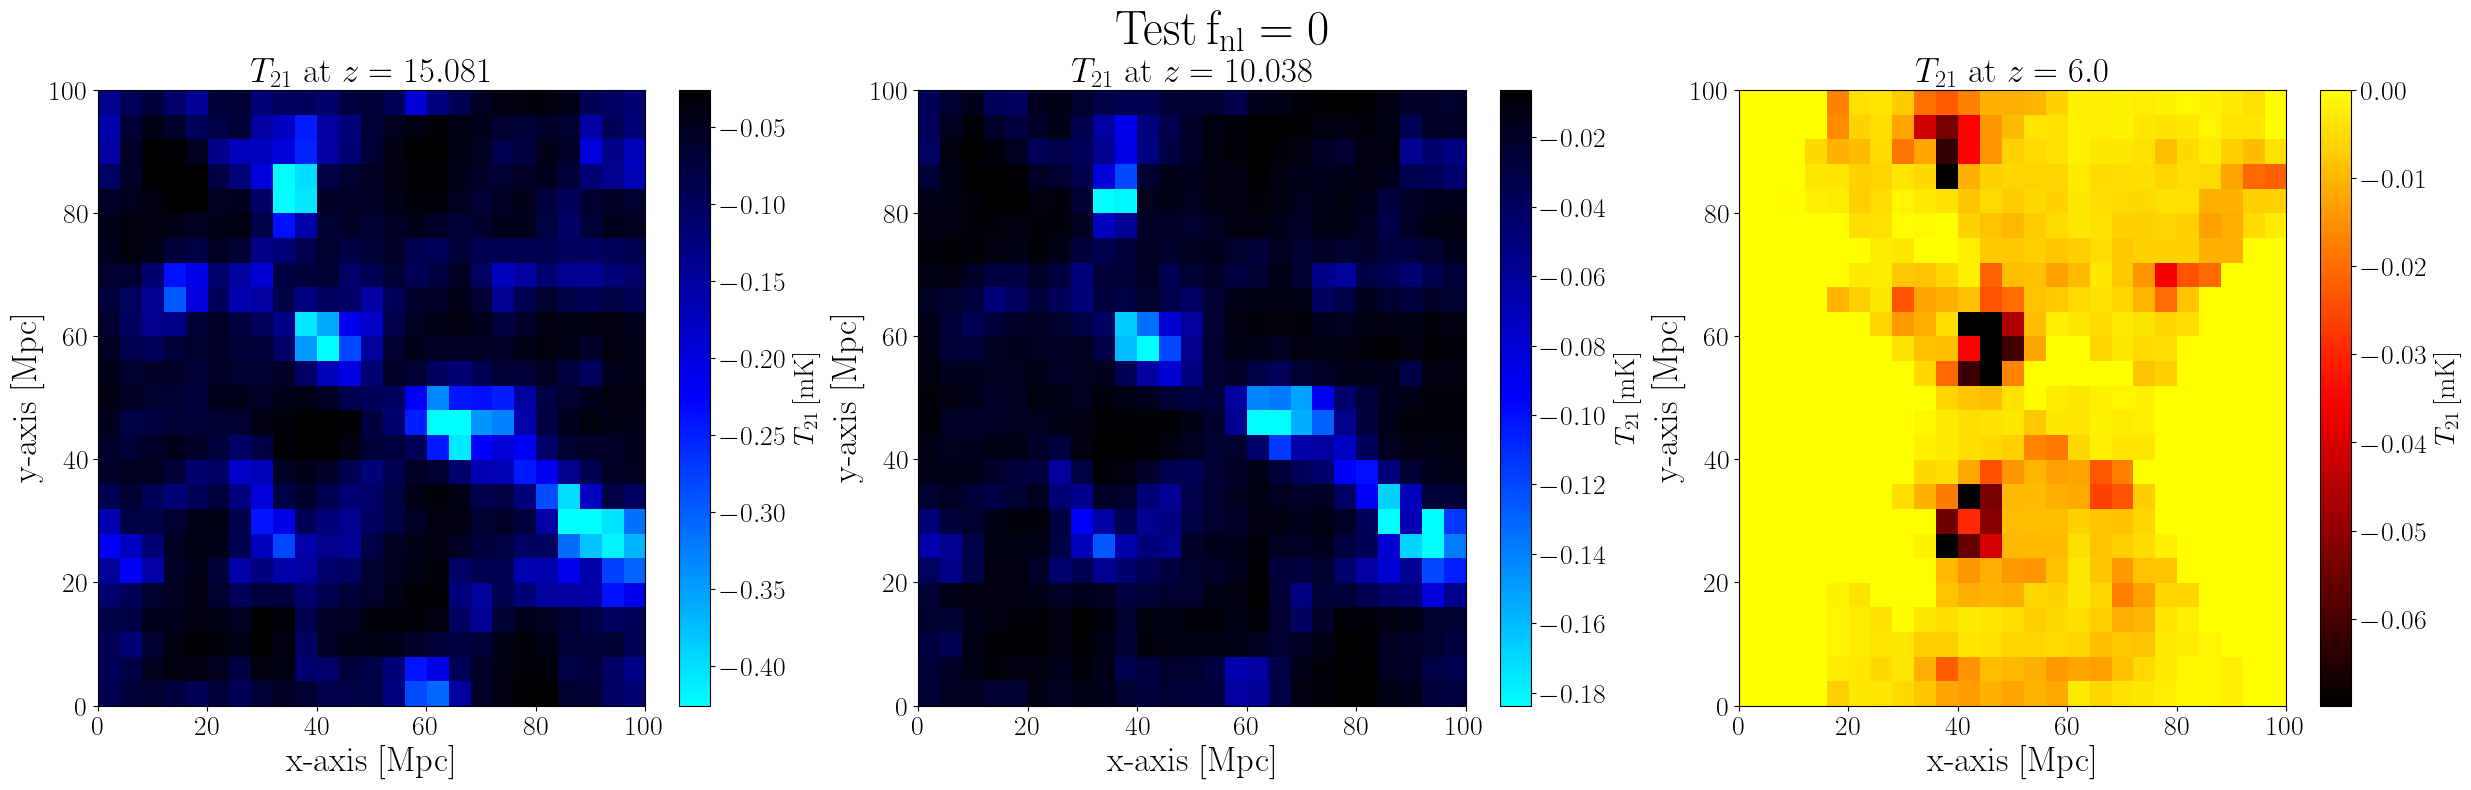

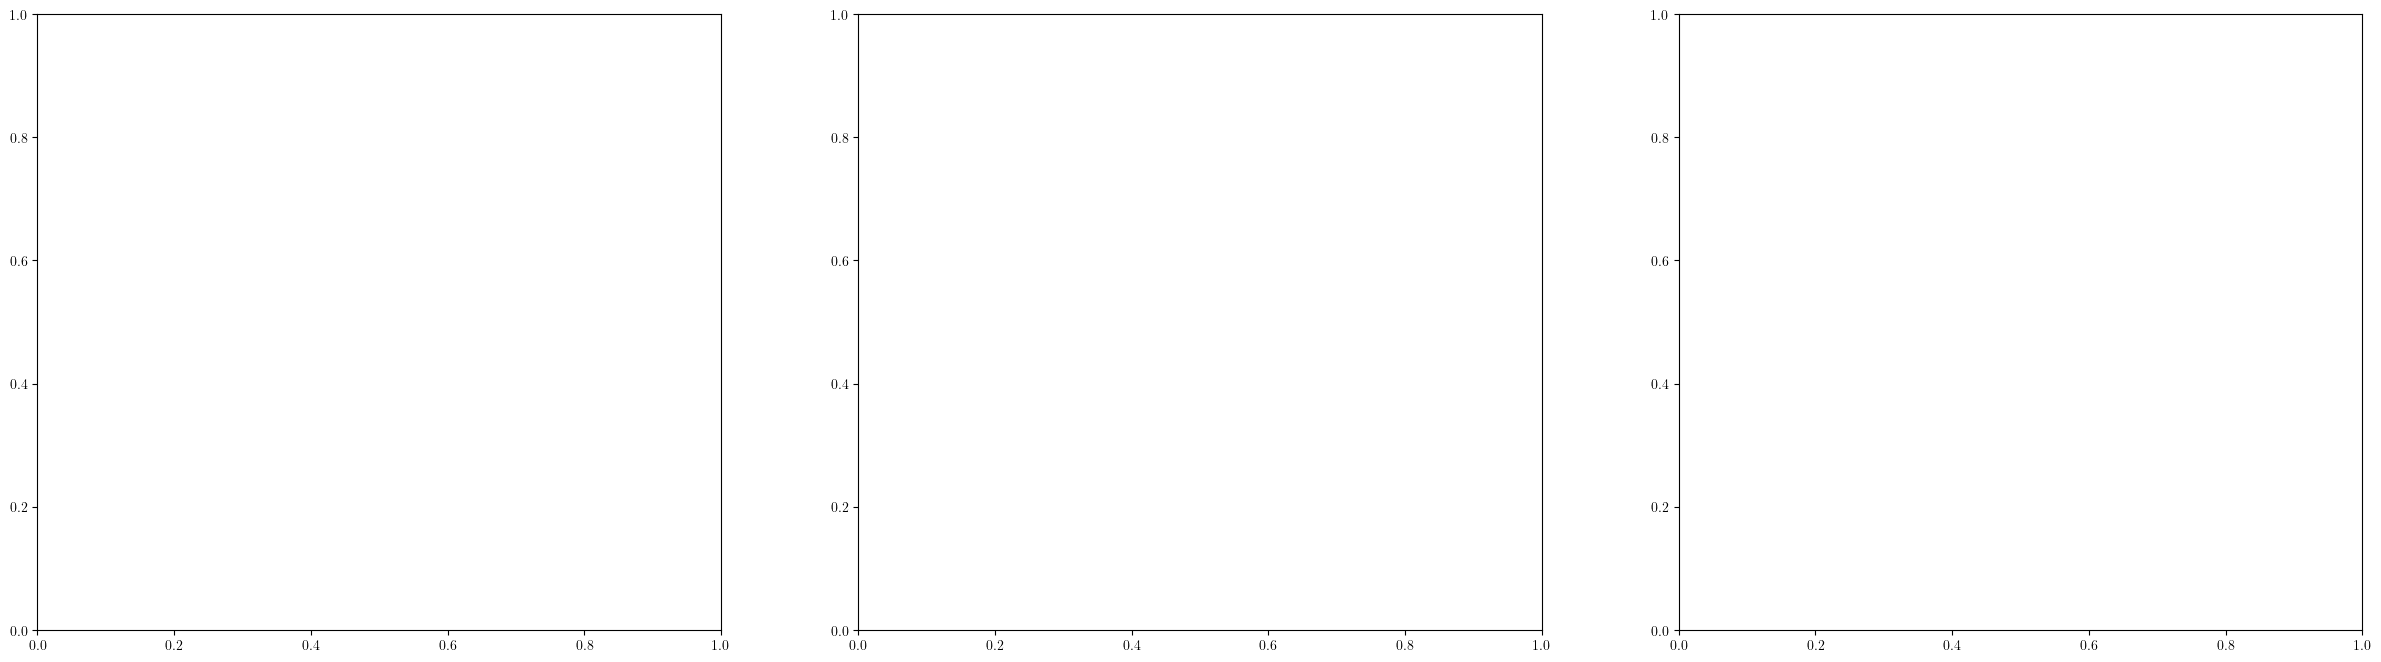

In [8]:
# Plot coeval boxes of the brightness temperature for different redshifts 

# plot the coeval boxes next to each other
figure, ax = plt.subplots(1, 3, figsize=(30, 8))

# fig = plotting.coeval_sliceplot(lightcone,
#                                  redshift=15,
#                                  ax=ax[0],
#                                  )
# fig = plotting.coeval_sliceplot(lightcone,
#                                  redshift=10,
#                                  ax=ax[1])
# fig = plotting.coeval_sliceplot(lightcone,
#                                  redshift=6,
#                                  ax=ax[2],)

figure.suptitle(r'$\rm Gaussian$',fontsize=35)

figure, ax = plt.subplots(1, 3, figsize=(30, 8))

fig = plotting.coeval_sliceplot(lightcone_NG0,
                                redshift=15,
                                ax=ax[0],
                                )

fig = plotting.coeval_sliceplot(lightcone_NG0,
                                redshift=10,
                                ax=ax[1])

fig = plotting.coeval_sliceplot(lightcone_NG0,
                                redshift=6,
                                ax=ax[2],)

figure.suptitle(r'$\rm Test\,f_{nl}=0$',fontsize=35)

figure, ax = plt.subplots(1, 3, figsize=(30, 8))

fig = plotting.coeval_sliceplot(lightcone_NG300,
                                redshift=15,
                                ax=ax[0],)

fig = plotting.coeval_sliceplot(lightcone_NG300,
                                redshift=10,
                                ax=ax[1],)

fig = plotting.coeval_sliceplot(lightcone_NG300,
                                redshift=6,
                                ax=ax[2],)

# figure.suptitle(r'$\rm Non-Gaussian,\,f_{nl}=300$',fontsize=35)

The default colormap for the brightness temperature in 21cmFirstCLASS is calibrated such that black regions correspond to null values (if the coeval box contains both positive and negative values). If only positive (negative) values in the coeval box exist, black regions correspond to the lowest (highest) values in the box.

We can also plot other coeval boxes we stored, like the kinetic temperature.

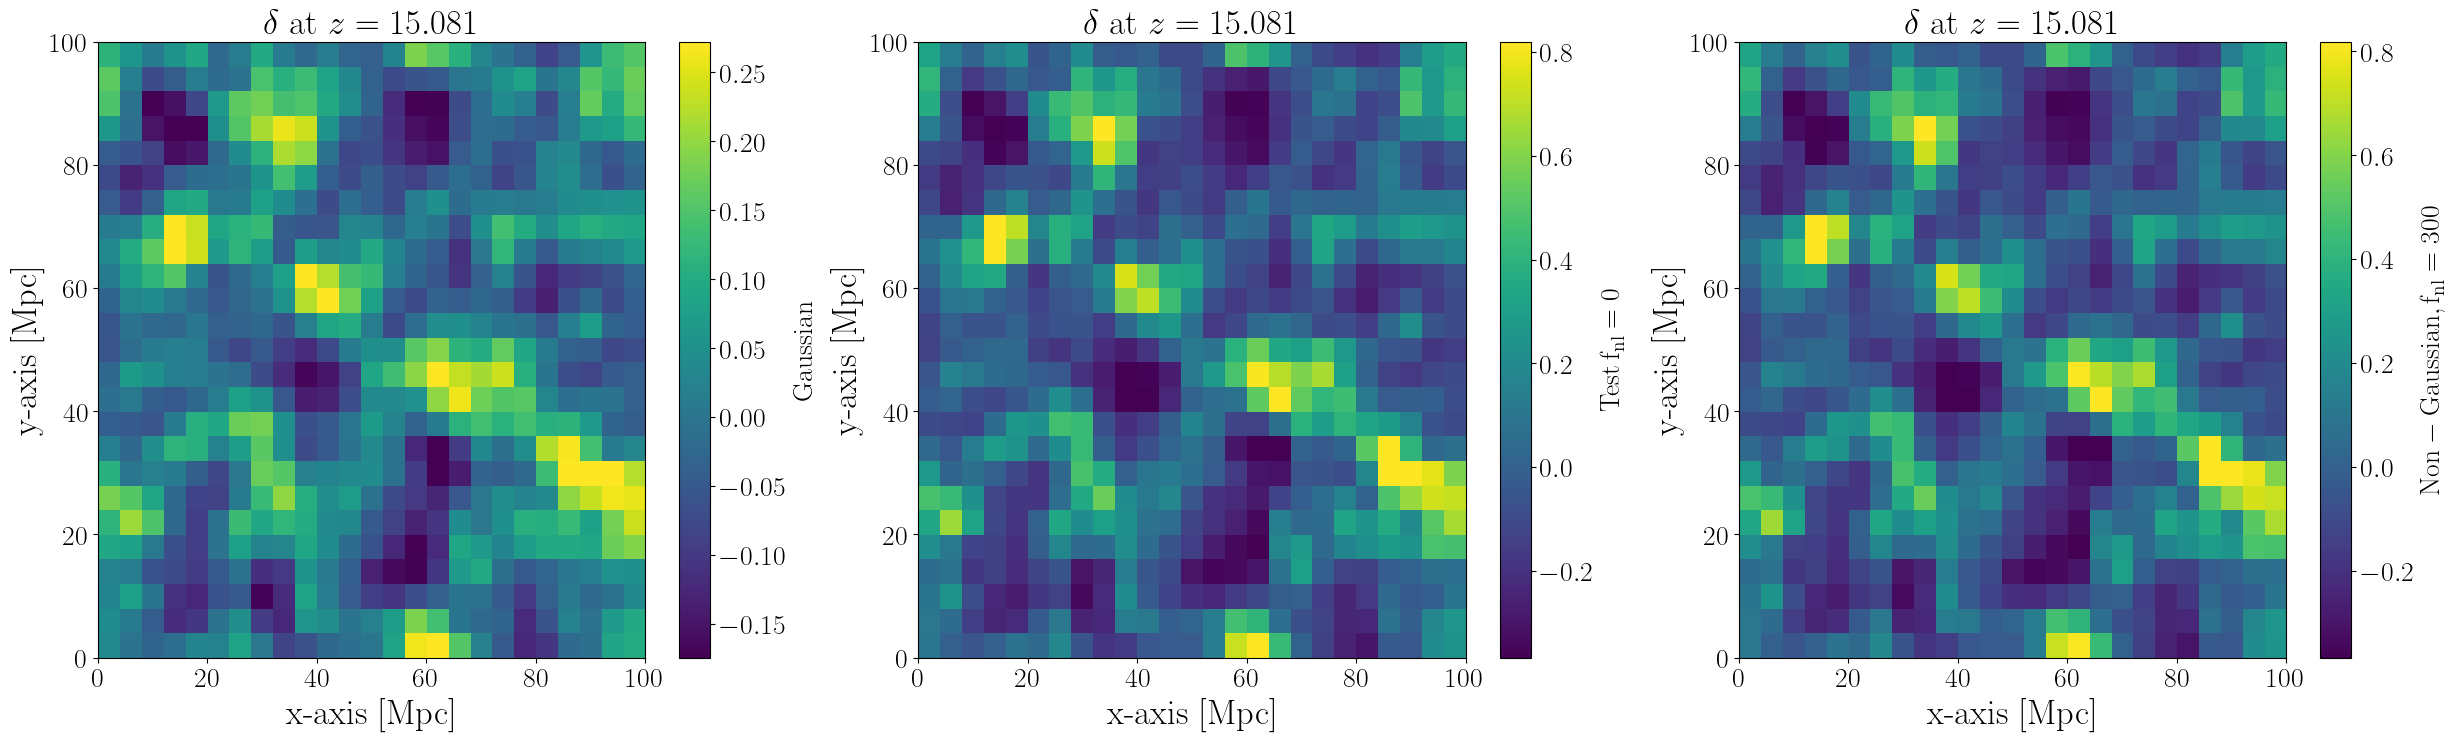

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(30, 8))
fig = plotting.coeval_sliceplot(lightcone,
                                        redshift=15,
                                        # you can specify the following properties for your plot; if None (or omitted) defaults are used
                                        kind='density',
                                        cbar=True, # whether or not to have a colorbar
                                        cbar_horizontal=None, # orientation of the colorbar
                                        ax = ax[0],
                                        cbar_label=r'$\rm Gaussian$'
                                        # Note that this function accepts all the arguments of 'matplotlib.pyplot.imshow'!
                                       )

fig = plotting.coeval_sliceplot(lightcone_NG0,
                                        redshift=15,
                                        # you can specify the following properties for your plot; if None (or omitted) defaults are used
                                        kind='density',
                                        cbar=True, # whether or not to have a colorbar
                                        cbar_horizontal=None, # orientation of the colorbar
                                        ax = ax[1],
                                        cbar_label=r'$\rm Test\,f_{nl}=0$'
                                        # Note that this function accepts all the arguments of 'matplotlib.pyplot.imshow'!
                                       )                    

fig = plotting.coeval_sliceplot(lightcone_NG300,
                                        redshift=15,
                                        # you can specify the following properties for your plot; if None (or omitted) defaults are used
                                        kind='density',
                                        cbar=True, # whether or not to have a colorbar
                                        cbar_horizontal=None, # orientation of the colorbar
                                        ax = ax[2],
                                        cbar_label=r'$\rm Non-Gaussian,f_{nl}=300$'
                                        # Note that this function accepts all the arguments of 'matplotlib.pyplot.imshow'!
                                       )              

In [13]:
lightcone_NG0.density-lightcone_NG300.density

array([[[ 0.00000000e+00,  9.58468765e-04,  2.30647624e-04, ...,
          3.30992043e-05,  4.06121835e-05,  3.03543638e-05],
        [ 0.00000000e+00,  1.27854943e-03,  1.16775744e-03, ...,
          5.22444025e-05,  2.55601481e-05,  2.91180331e-05],
        [ 0.00000000e+00,  7.81640410e-04,  1.14436448e-03, ...,
          3.36430967e-05,  6.81728125e-07, -7.25407153e-06],
        ...,
        [ 0.00000000e+00, -5.22747636e-04,  6.31093979e-04, ...,
         -1.34147704e-05,  6.10481948e-07, -6.68317080e-06],
        [ 0.00000000e+00,  2.13706493e-03,  3.50308418e-03, ...,
         -2.76789069e-05, -2.40858644e-05, -5.77419996e-06],
        [ 0.00000000e+00, -3.13872099e-03, -5.78629971e-03, ...,
         -2.82255933e-05, -1.79558992e-05,  1.44657679e-05]],

       [[ 0.00000000e+00,  9.01076943e-04,  2.09167600e-03, ...,
          1.34552829e-05,  1.79037597e-05,  5.79468906e-06],
        [ 0.00000000e+00,  2.33115256e-03,  1.68935582e-03, ...,
          2.42241658e-05,  2.42129900e

In [ ]:
lightcone_NG0.brightness_temp-lightcone_NG300.brightness_temp

array([[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00, -3.0449883e-09,  6.5192580e-09, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        ...,
        [ 0.0000000e+00,  8.1490725e-10,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

       [[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00, -2.1827873e-11, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00, 